In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    """一个基本的残差块，用于 ResNet-18 和 ResNet-34"""
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def resnet18(num_classes=1000):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = resnet18(num_classes=176).to(device)


In [2]:
model.load_state_dict(torch.load("model.pth", weights_only=True))


<All keys matched successfully>

In [3]:
# 权重匹配
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
import json

# 从 JSON 文件加载标签映射
with open('label_mapping.json', 'r') as f:
    label_mapping = json.load(f)

# 检查加载的标签映射
print(label_mapping)


['maclura_pomifera', 'ulmus_rubra', 'broussonettia_papyrifera', 'prunus_virginiana', 'acer_rubrum', 'cryptomeria_japonica', 'staphylea_trifolia', 'asimina_triloba', 'diospyros_virginiana', 'tilia_cordata', 'ulmus_pumila', 'quercus_muehlenbergii', 'juglans_cinerea', 'cercis_canadensis', 'ptelea_trifoliata', 'acer_palmatum', 'catalpa_speciosa', 'abies_concolor', 'eucommia_ulmoides', 'quercus_montana', 'koelreuteria_paniculata', 'liriodendron_tulipifera', 'styrax_japonica', 'malus_pumila', 'prunus_sargentii', 'cornus_mas', 'magnolia_virginiana', 'ostrya_virginiana', 'magnolia_acuminata', 'ilex_opaca', 'acer_negundo', 'fraxinus_nigra', 'pyrus_calleryana', 'picea_abies', 'chionanthus_virginicus', 'carpinus_caroliniana', 'zelkova_serrata', 'aesculus_pavi', 'taxodium_distichum', 'carya_tomentosa', 'picea_pungens', 'carya_glabra', 'quercus_macrocarpa', 'carya_cordiformis', 'catalpa_bignonioides', 'tsuga_canadensis', 'populus_tremuloides', 'magnolia_denudata', 'crataegus_viridis', 'populus_delt

In [5]:
# 预测
import os
import pandas as pd
from PIL import Image
from torchvision import transforms

# 定义包含测试图片的目录

image_dir = './data/test'  # 假设图片存储在名为 'images' 的文件夹中
output_csv = 'predictions.csv'  # 输出的CSV文件名

# 定义测试图片的变换（根据你模型的输入要求进行调整）
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 调整为模型所需的输入尺寸
    transforms.ToTensor()  # 按照预训练模型的标准化要求进行处理
])

# 加载你训练好的模型
# model = torch.load('model.pth')
model.eval()  # 设置模型为评估模式


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:

# 用于存储结果的列表
results = []

# 遍历测试图片
for filename in os.listdir(image_dir):
    if filename.endswith('.jpg'):  # 确保只处理 .jpg 文件
        # 构建图片的完整路径
        img_path = os.path.join(image_dir , filename)
        
        # 加载图片
        image = Image.open(img_path).convert('RGB')
        image = transform(image)
        image = image.unsqueeze(0)  # 添加批次维度
        image = image.to(device)  # gpu
        # 进行预测
        with torch.no_grad():
            output = model(image)
            _, predicted = torch.max(output, 1)
        
        # 使用标签映射将预测的索引值转换为标签文本
        label = label_mapping[predicted.item()]
        print(f"预测标签: {label}") 
        # 替换为你的标签映射
        
        str = 'images'
        # 保存结果
        results.append([os.path.join(str , filename), label])
        results = [[path.replace('\\', '/'), label] for path, label in results]

# 创建DataFrame并保存为CSV文件
df = pd.DataFrame(results, columns=['image', 'label'])
df.to_csv(output_csv, index=False)

print(f"预测结果已保存到 {output_csv}")

预测标签: asimina_triloba
预测标签: paulownia_tomentosa
预测标签: populus_deltoides
预测标签: pinus_koraiensis
预测标签: platanus_occidentalis
预测标签: koelreuteria_paniculata
预测标签: magnolia_tripetala
预测标签: metasequoia_glyptostroboides
预测标签: tilia_cordata
预测标签: amelanchier_arborea
预测标签: quercus_marilandica
预测标签: quercus_muehlenbergii
预测标签: asimina_triloba
预测标签: castanea_dentata
预测标签: pinus_echinata
预测标签: metasequoia_glyptostroboides
预测标签: picea_pungens
预测标签: quercus_michauxii
预测标签: pinus_bungeana
预测标签: cryptomeria_japonica
预测标签: fraxinus_pennsylvanica
预测标签: morus_alba
预测标签: cercis_canadensis
预测标签: ptelea_trifoliata
预测标签: halesia_tetraptera
预测标签: liriodendron_tulipifera
预测标签: acer_rubrum
预测标签: pinus_bungeana
预测标签: quercus_montana
预测标签: cornus_mas
预测标签: magnolia_tripetala
预测标签: ficus_carica
预测标签: carya_glabra
预测标签: quercus_palustris
预测标签: prunus_virginiana
预测标签: maclura_pomifera
预测标签: magnolia_macrophylla
预测标签: acer_palmatum
预测标签: picea_orientalis
预测标签: abies_concolor
预测标签: magnolia_virginiana
预测标签: liriodendr

KeyboardInterrupt: 

In [16]:

import os
from PIL import Image
import matplotlib.pyplot as plt
import torch

def predict_and_display_images(image_dir, model, transform, device, label_mapping):
    """
    遍历测试图片，进行预测并显示图片。

    参数:
    - image_dir: 图片所在目录的路径
    - model: 训练好的模型
    - transform: 对图片的预处理转换
    - device: 模型运行的设备 (CPU 或 GPU)
    - label_mapping: 标签映射字典，将预测索引转换为标签文本
    """
    # 遍历目录中的每个图片文件
    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg'):  # 确保只处理 .jpg 文件
            # 构建图片的完整路径
            img_path = os.path.join(image_dir, filename)
            
            # 加载图片
            image = Image.open(img_path).convert('RGB')
            
            # 显示图片
            plt.imshow(image)
            plt.title(f"Image: {filename}")
            plt.axis('off')
            plt.show()
            
            # 进行预测
            image_transformed = transform(image)
            image_transformed = image_transformed.unsqueeze(0)  # 添加批次维度
            image_transformed = image_transformed.to(device)  # 移动到设备
            
            with torch.no_grad():
                output = model(image_transformed)
                _, predicted = torch.max(output, 1)
            
            # 使用标签映射将预测的索引值转换为标签文本
            label = label_mapping[predicted.item()]
            print(f"预测标签: {label}")
        
 


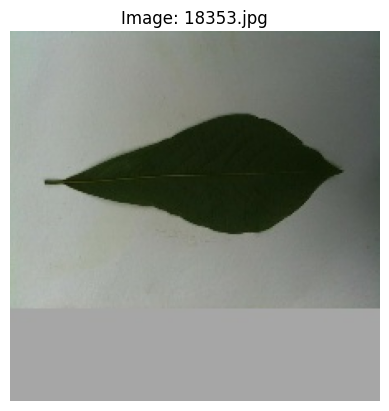

预测标签: asimina_triloba


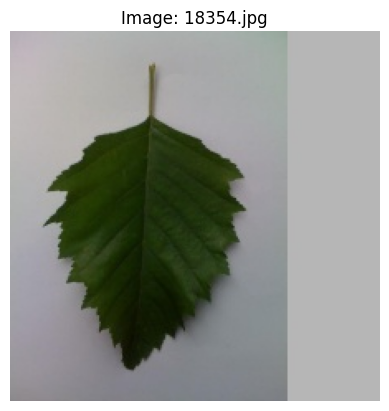

预测标签: paulownia_tomentosa


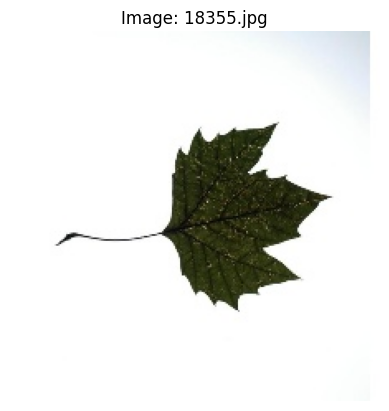

预测标签: populus_deltoides


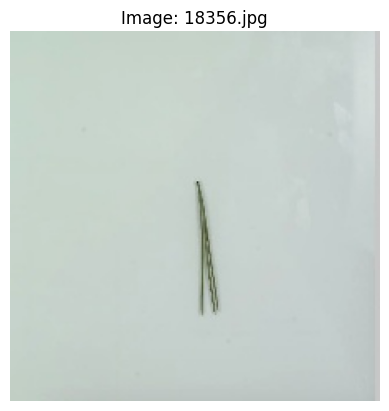

预测标签: pinus_koraiensis


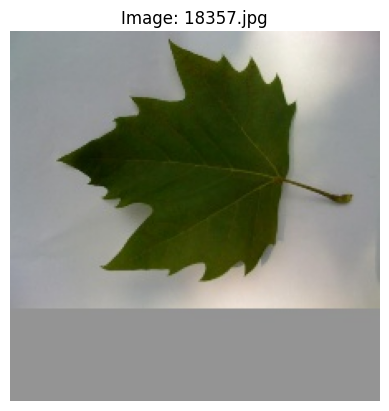

预测标签: platanus_occidentalis


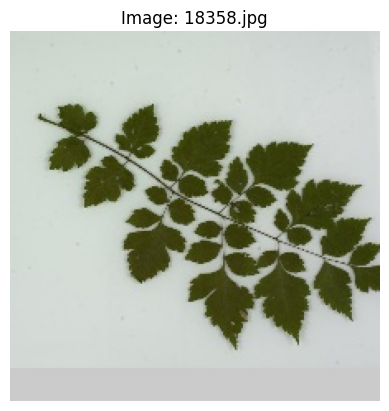

预测标签: koelreuteria_paniculata


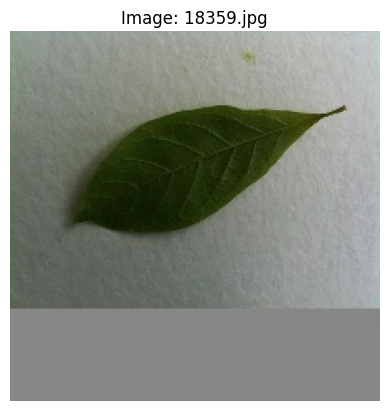

预测标签: magnolia_tripetala


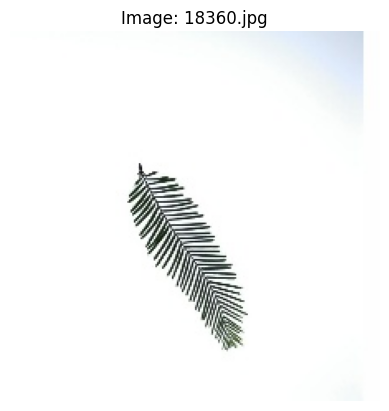

预测标签: metasequoia_glyptostroboides


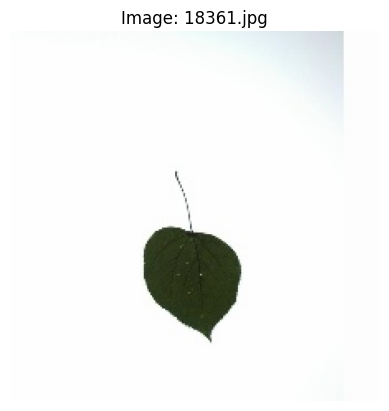

预测标签: tilia_cordata


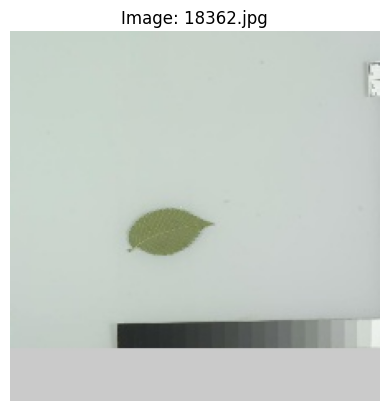

预测标签: amelanchier_arborea


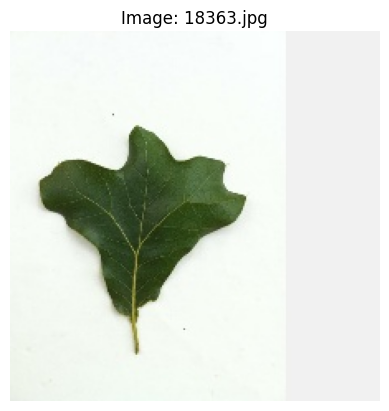

预测标签: quercus_marilandica


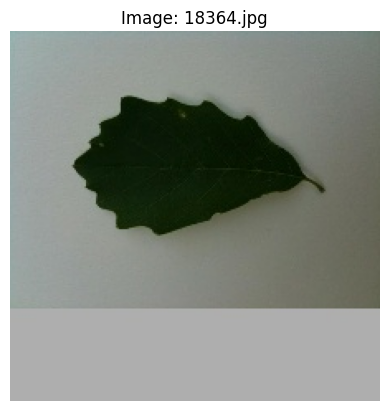

预测标签: quercus_muehlenbergii


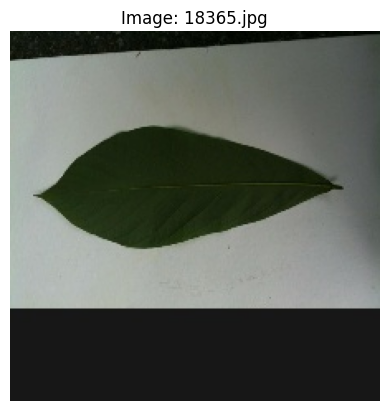

预测标签: asimina_triloba


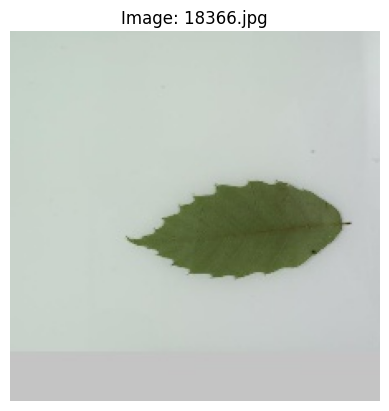

预测标签: castanea_dentata


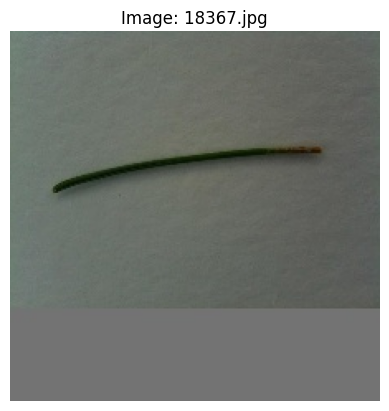

预测标签: pinus_echinata


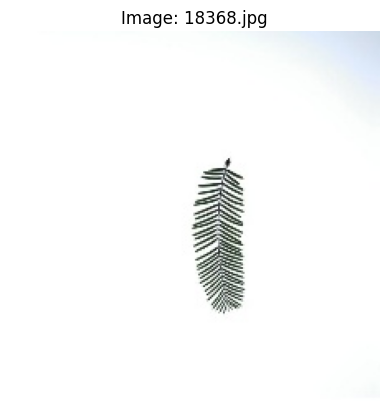

预测标签: metasequoia_glyptostroboides


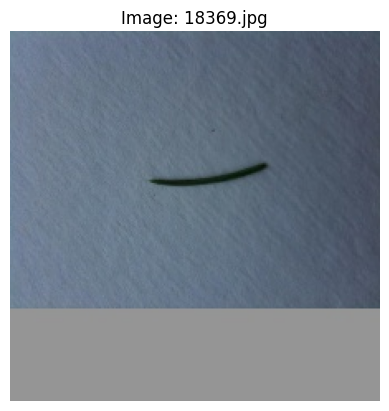

预测标签: picea_pungens


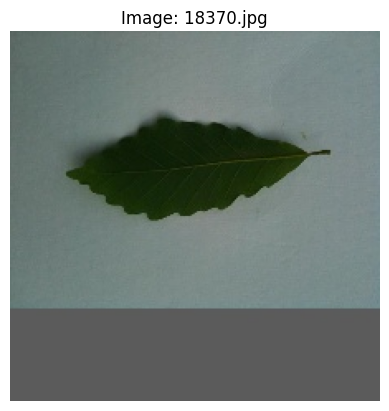

预测标签: quercus_michauxii


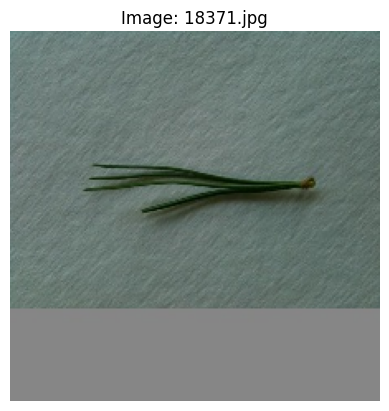

预测标签: pinus_bungeana


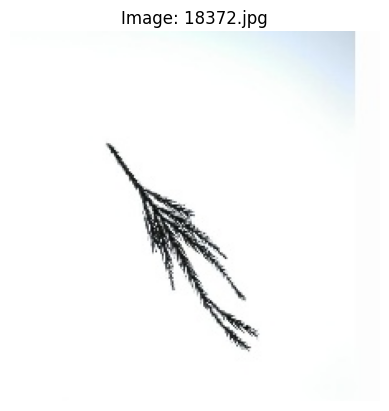

预测标签: cryptomeria_japonica


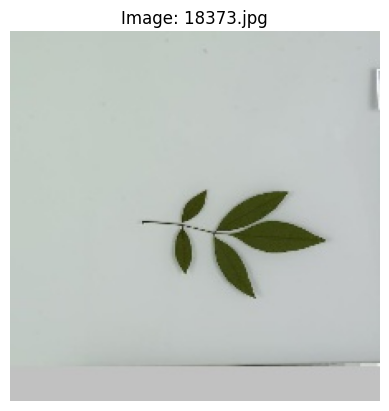

预测标签: fraxinus_pennsylvanica


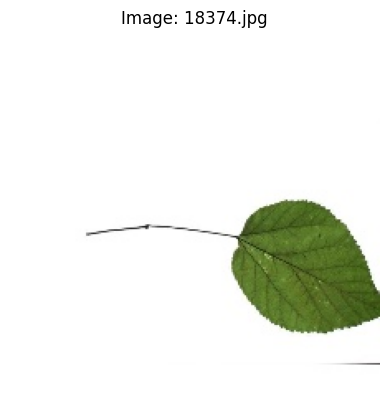

预测标签: morus_alba


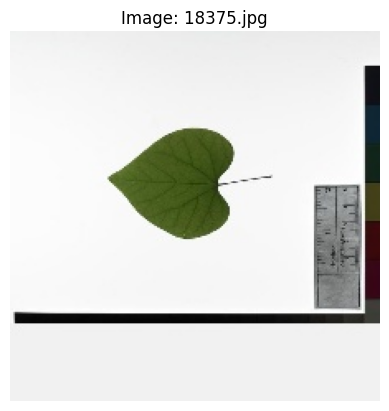

预测标签: cercis_canadensis


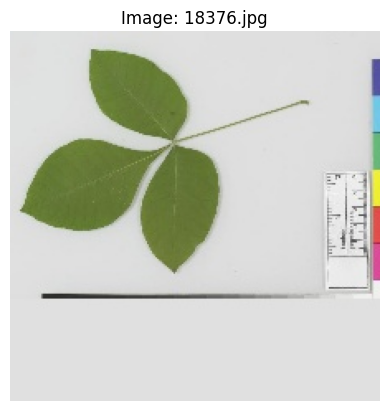

预测标签: ptelea_trifoliata


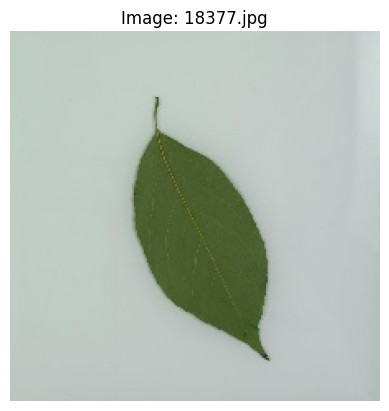

预测标签: halesia_tetraptera


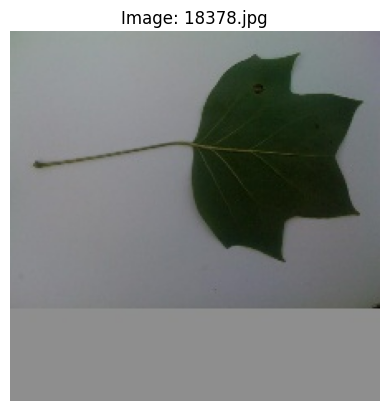

预测标签: liriodendron_tulipifera


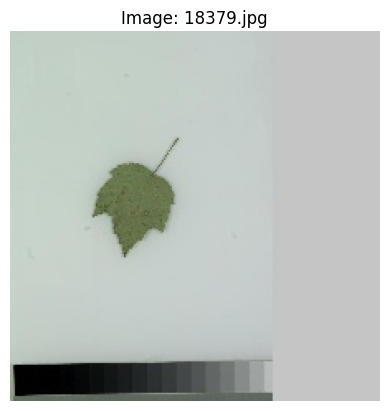

预测标签: acer_rubrum


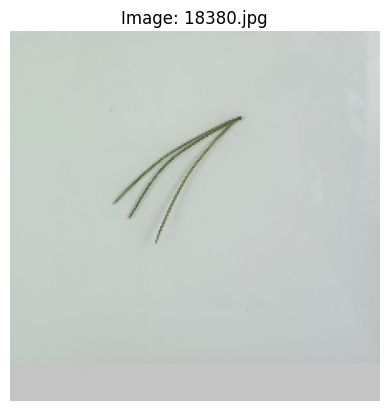

预测标签: pinus_bungeana


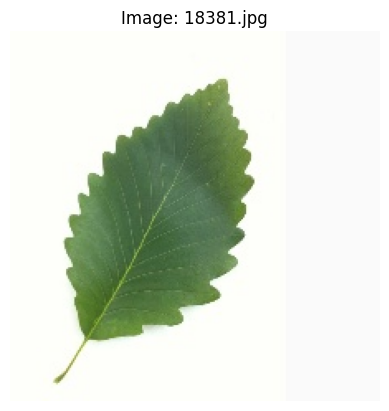

预测标签: quercus_montana


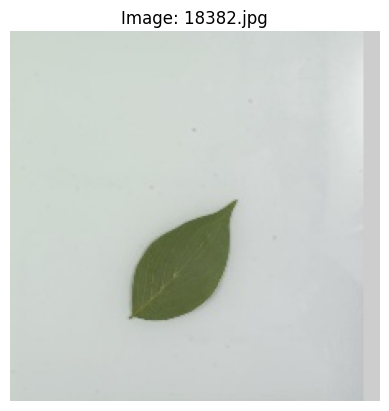

预测标签: cornus_mas


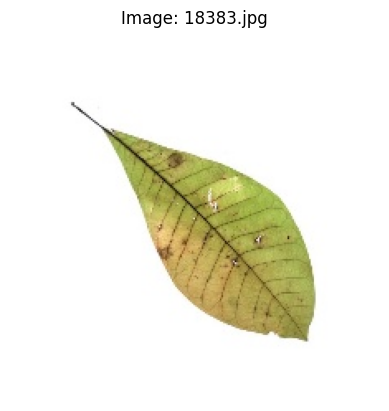

预测标签: magnolia_tripetala


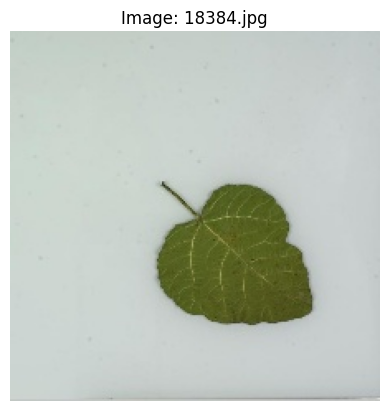

预测标签: ficus_carica


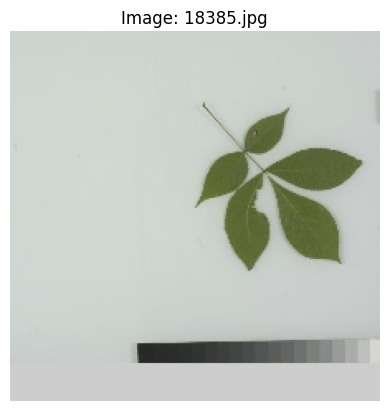

预测标签: carya_glabra


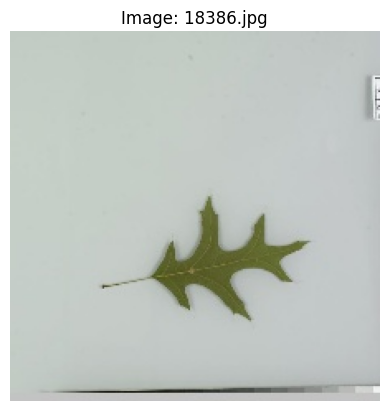

预测标签: quercus_palustris


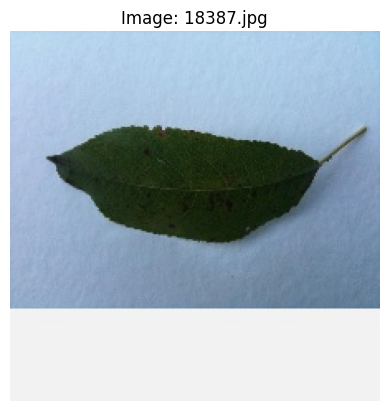

预测标签: prunus_virginiana


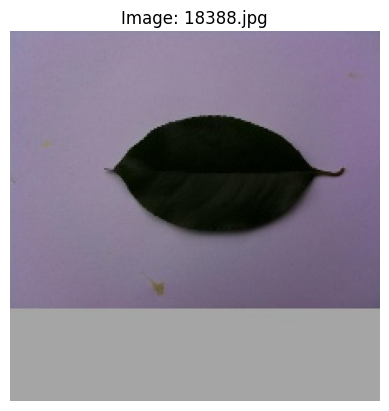

预测标签: maclura_pomifera


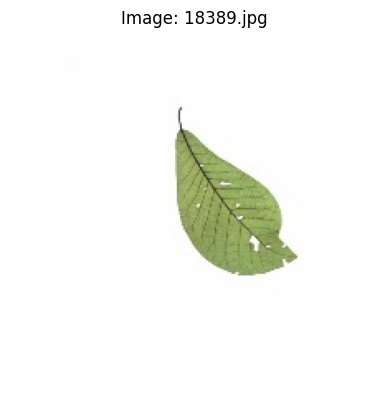

预测标签: magnolia_macrophylla


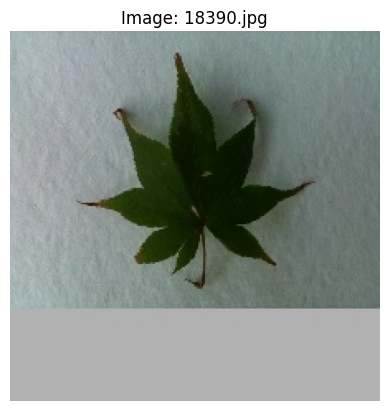

预测标签: acer_palmatum


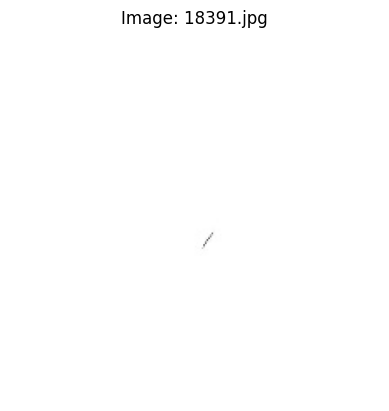

预测标签: picea_orientalis


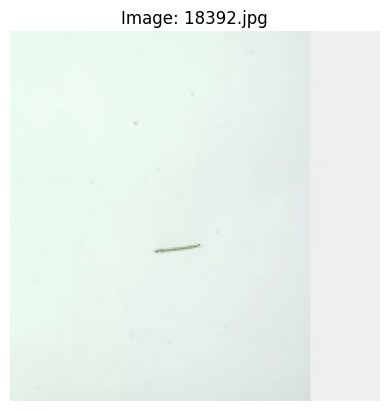

预测标签: abies_concolor


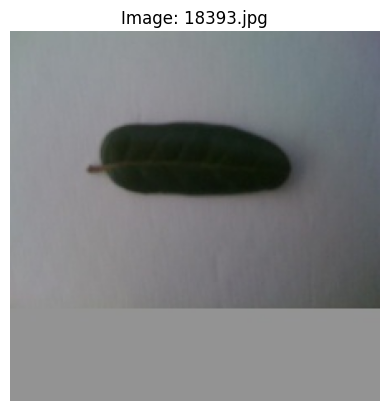

预测标签: magnolia_virginiana


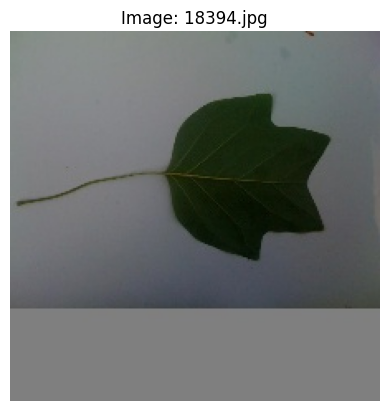

预测标签: liriodendron_tulipifera


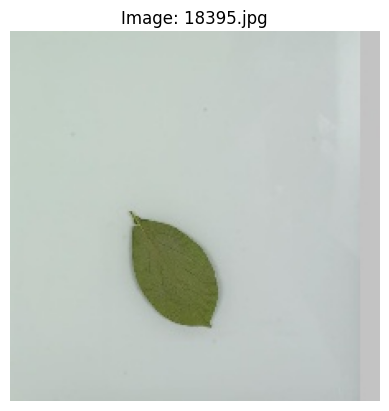

预测标签: stewartia_pseudocamellia


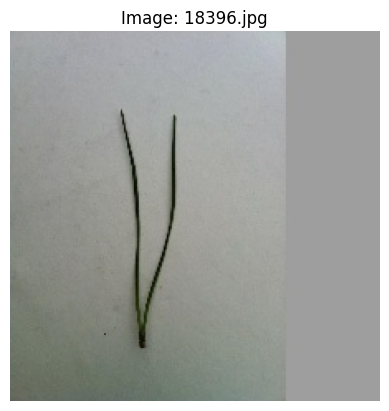

预测标签: pinus_rigida


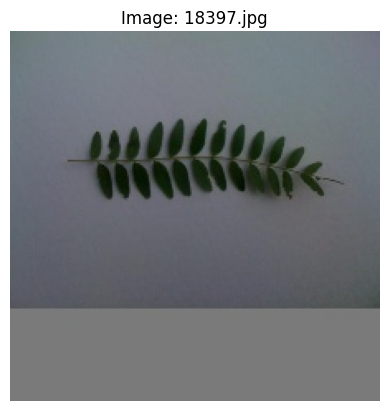

预测标签: gleditsia_triacanthos


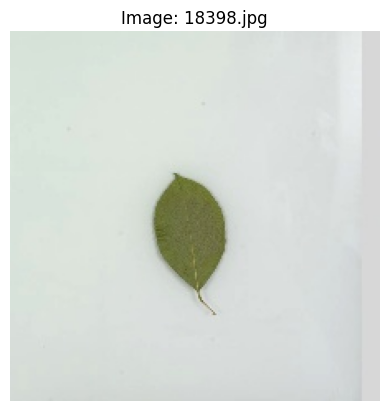

预测标签: tilia_cordata


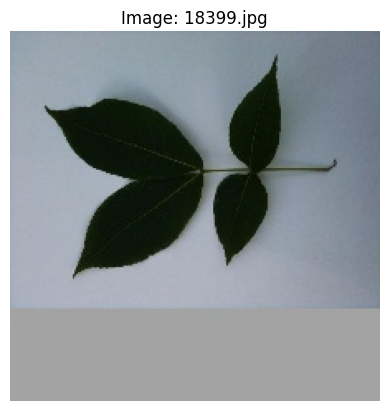

预测标签: carya_glabra


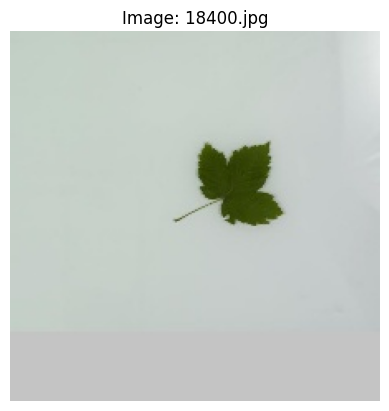

预测标签: acer_pseudoplatanus


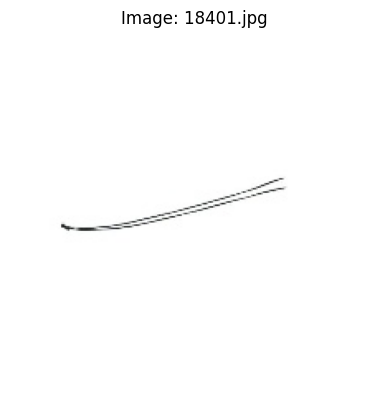

预测标签: pinus_resinosa


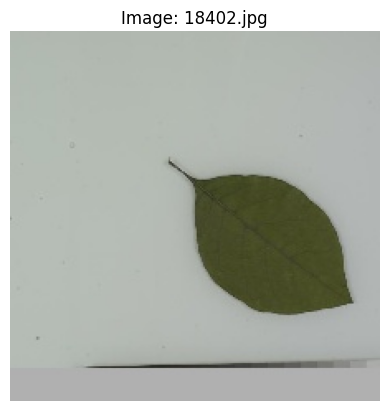

预测标签: chionanthus_virginicus


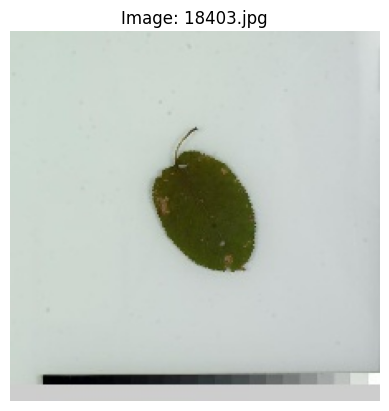

预测标签: amelanchier_laevis


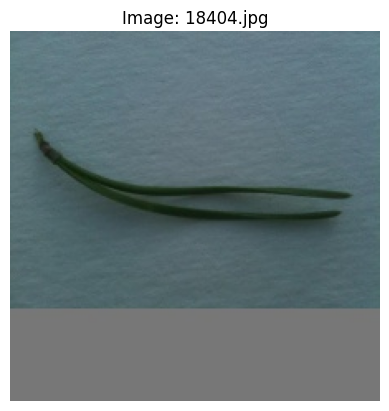

预测标签: prunus_virginiana


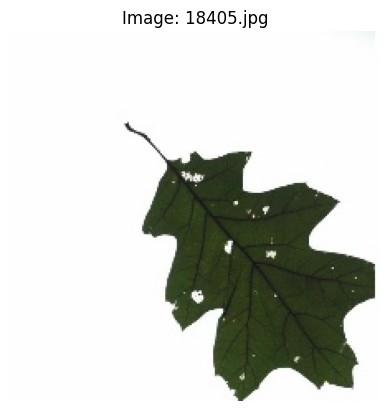

预测标签: quercus_velutina


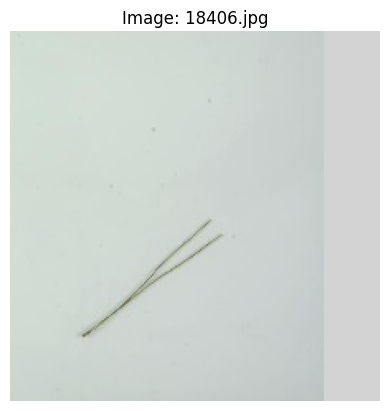

预测标签: pinus_thunbergii


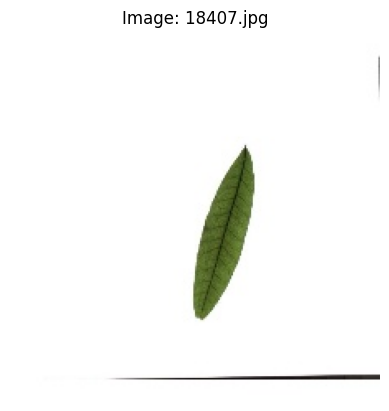

预测标签: quercus_phellos


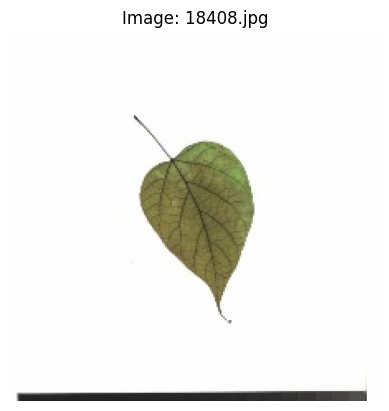

预测标签: acer_pensylvanicum


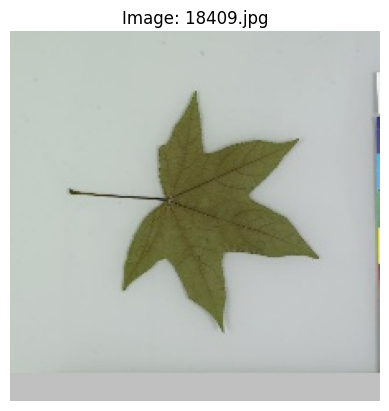

预测标签: liquidambar_styraciflua


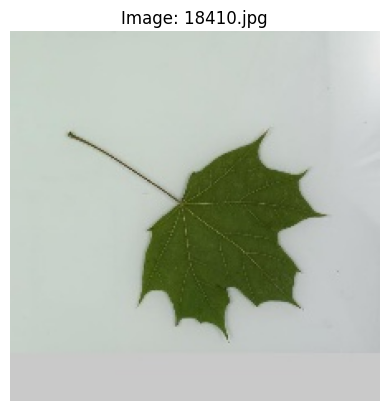

预测标签: acer_platanoides


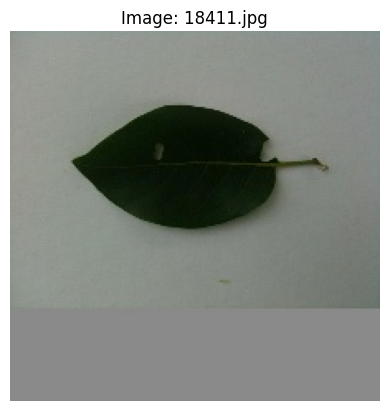

预测标签: diospyros_virginiana


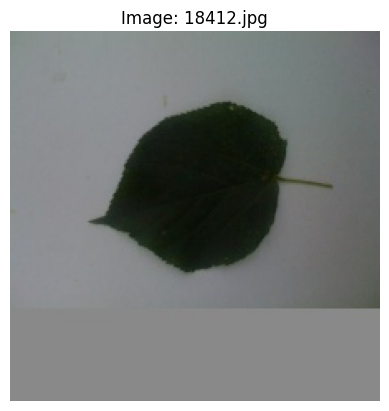

预测标签: tilia_cordata


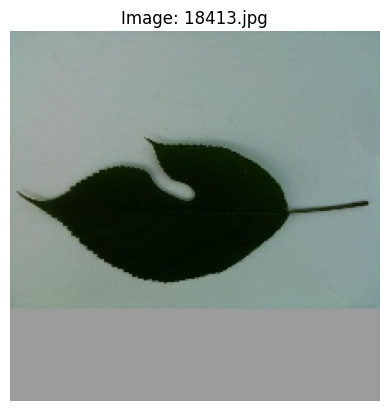

预测标签: carya_glabra


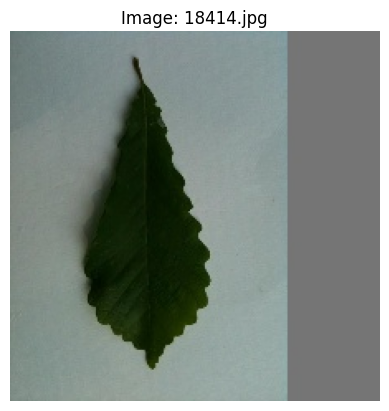

预测标签: quercus_michauxii


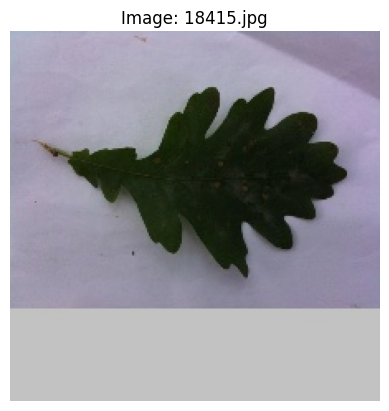

预测标签: aesculus_hippocastamon


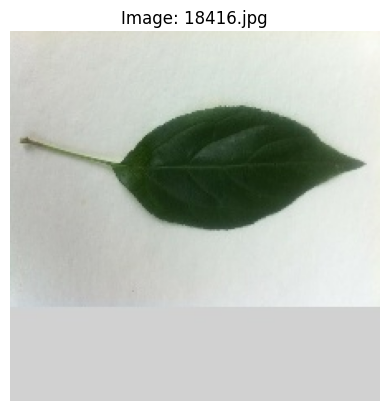

预测标签: malus_coronaria


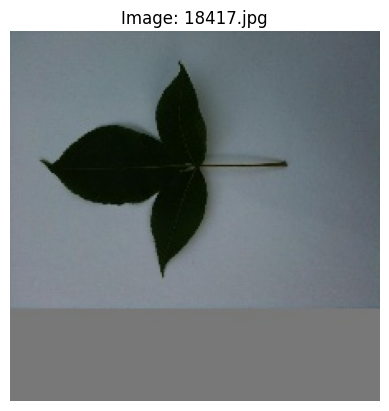

预测标签: carya_glabra


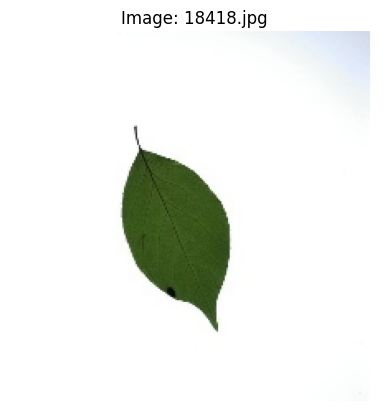

预测标签: cornus_mas


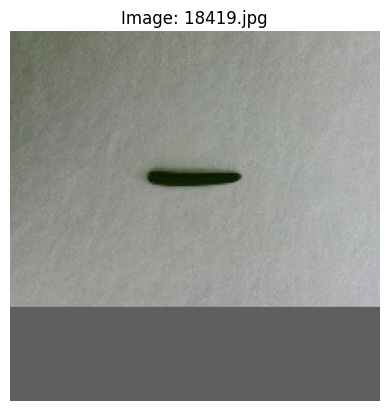

预测标签: metasequoia_glyptostroboides


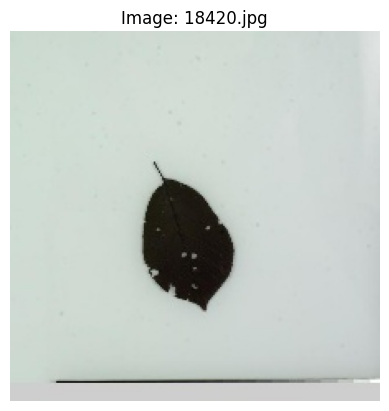

预测标签: populus_tremuloides


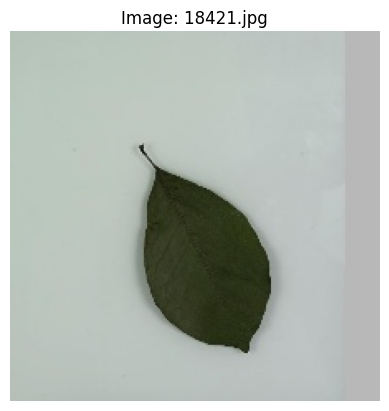

预测标签: magnolia_denudata


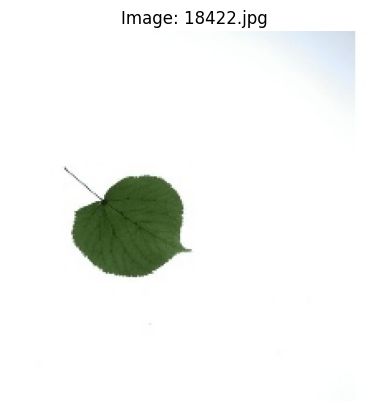

预测标签: tilia_europaea


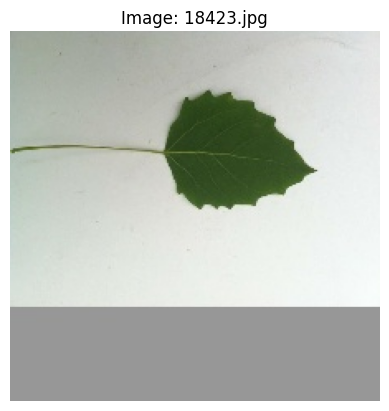

预测标签: populus_tremuloides


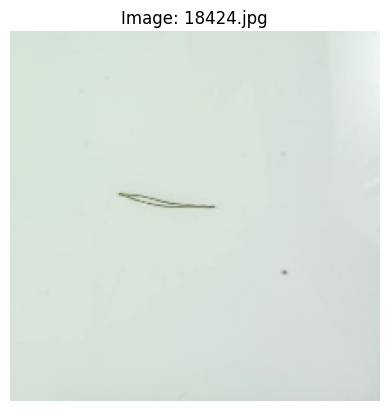

预测标签: pinus_virginiana


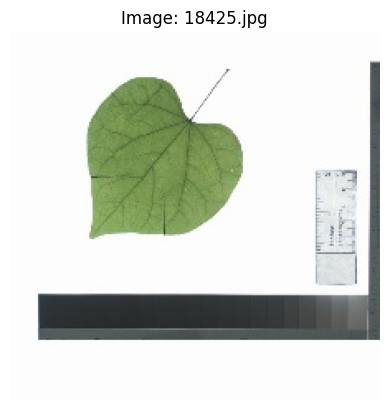

预测标签: tilia_americana


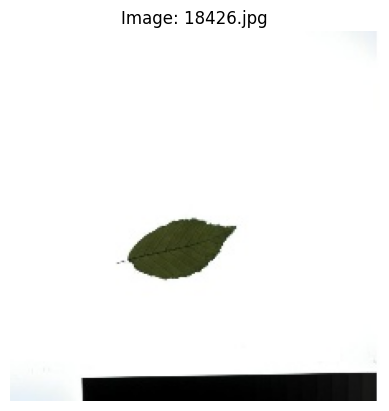

预测标签: carpinus_caroliniana


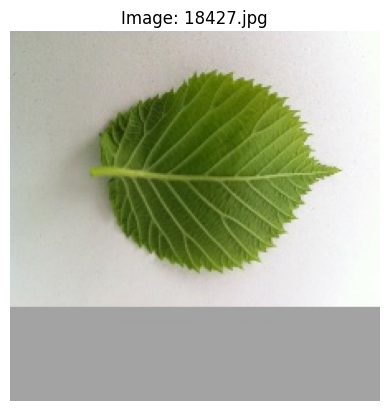

预测标签: ulmus_glabra


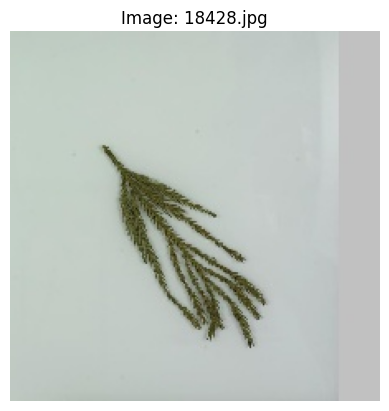

预测标签: cryptomeria_japonica


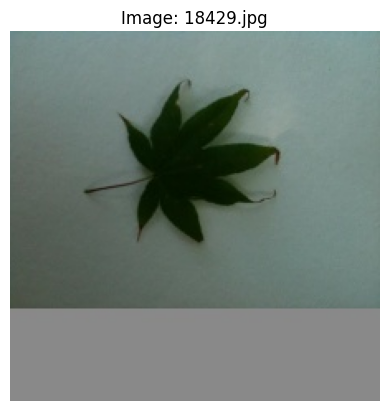

预测标签: acer_palmatum


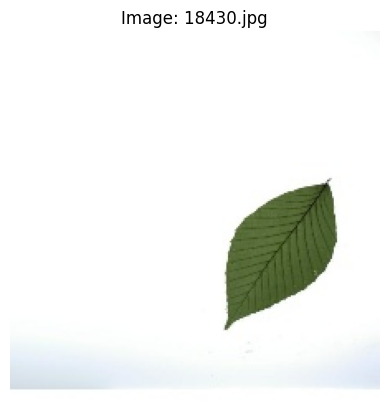

预测标签: fagus_grandifolia



KeyboardInterrupt



In [18]:
predict_and_display_images(image_dir='./data/test', model=model,
                          transform=transform,device='cuda',label_mapping=label_mapping) 